In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

import torch
from pipeline import AnomalyDetectionPipeline
import preprocessing as prep

In [2]:
data = 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz'
lobster_ob = "data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv"
lobster_msg = "data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_10.csv"

In [3]:
# Initialize Pipeline
pipeline = AnomalyDetectionPipeline(seq_length=25, batch_size=128)

# Load Data
nrows = 40_000
try:
    df_lobster = prep.load_lobster_data(orderbook_path=lobster_ob, message_path=lobster_msg, levels=10, nrows=nrows)
    pipeline.raw_df = df_lobster
except Exception as e:
    print(f"Error loading data: {e}")

# pipeline.load_data(data, nrows=nrows)

# Engineer Features
selected_features = ['base', 'tao', 'hawkes', 'poutre']
pipeline.engineer_features(feature_sets=selected_features)

# Preprocess Data
pipeline.scale_and_sequence(method='box-cox', train_split=0.7)

Pipeline initialized on device: cuda
Loading LOBSTER data from data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv...
Successfully loaded 40000 LOBSTER rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre']...
Feature Engineering complete. Total features: 121
Preprocessing with method: box-cox...
Dropping 12 constant/zero-variance features: ['Hawkes_L_bid_beta1000_Eta1.0', 'Hawkes_L_bid_beta100_Eta10.0', 'Hawkes_L_bid_beta10_Eta10.0', 'Hawkes_L_ask_beta100_Eta1.0', 'Hawkes_L_ask_beta1000_Eta1.0', 'Hawkes_L_bid_beta100_Eta1.0', 'Hawkes_L_bid_beta1000_Eta10.0', 'Hawkes_L_ask_beta10_Eta1.0', 'Hawkes_L_ask_beta100_Eta10.0', 'Hawkes_L_ask_beta1000_Eta10.0', 'Hawkes_L_ask_beta10_Eta10.0', 'Hawkes_L_bid_beta10_Eta1.0']
Data split: Train (27982, 25, 109), Test (11993, 25, 109)


In [4]:
# Train Transformer + OC-SVM Model
pipeline.train_model(
    model_type='transformer_ocsvm', 
    epochs=10, 
    lr=1e-3,
    nu=0.01
)

Initializing Transformer Autoencoder...
Training Autoencoder...
Epoch 1/10 - Loss: 0.667395
Epoch 2/10 - Loss: 0.472331
Epoch 3/10 - Loss: 0.381498
Epoch 4/10 - Loss: 0.285589
Epoch 5/10 - Loss: 0.229908
Epoch 6/10 - Loss: 0.195383
Epoch 7/10 - Loss: 0.171158
Epoch 8/10 - Loss: 0.153103
Epoch 9/10 - Loss: 0.140182
Epoch 10/10 - Loss: 0.129618
Extracting Latent Representations for OC-SVM...
Training One-Class SVM (nu=0.01)...


Detected 120 anomalies in test set.


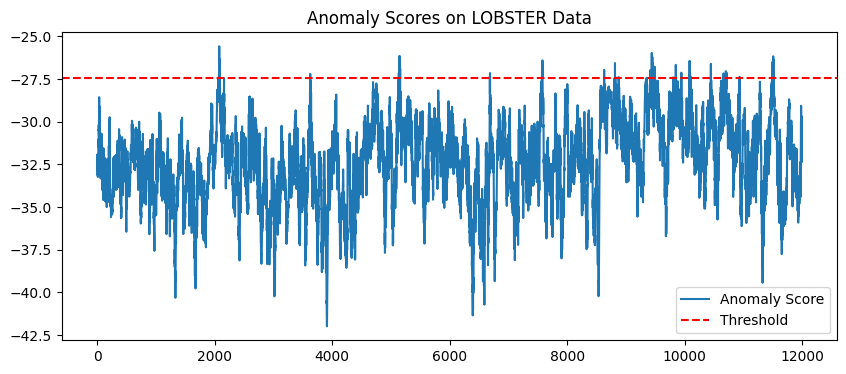

In [5]:
# Scan for anomalies using Transformer + OC-SVM
z_test = pipeline._get_latent(pipeline.X_test)
z_test_scaled = pipeline.latent_scaler.transform(z_test)
anomaly_scores = - pipeline.detector.score_samples(z_test_scaled) # Higher = more anomalous

threshold = np.percentile(anomaly_scores, 99)  # 99th percentile
anomalies_idx = np.where(anomaly_scores > threshold)[0]
print(f"Detected {len(anomalies_idx)} anomalies in test set.")

plt.figure(figsize=(10, 4))
plt.plot(anomaly_scores, label='Anomaly Score')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores on LOBSTER Data')
plt.legend()
plt.show()

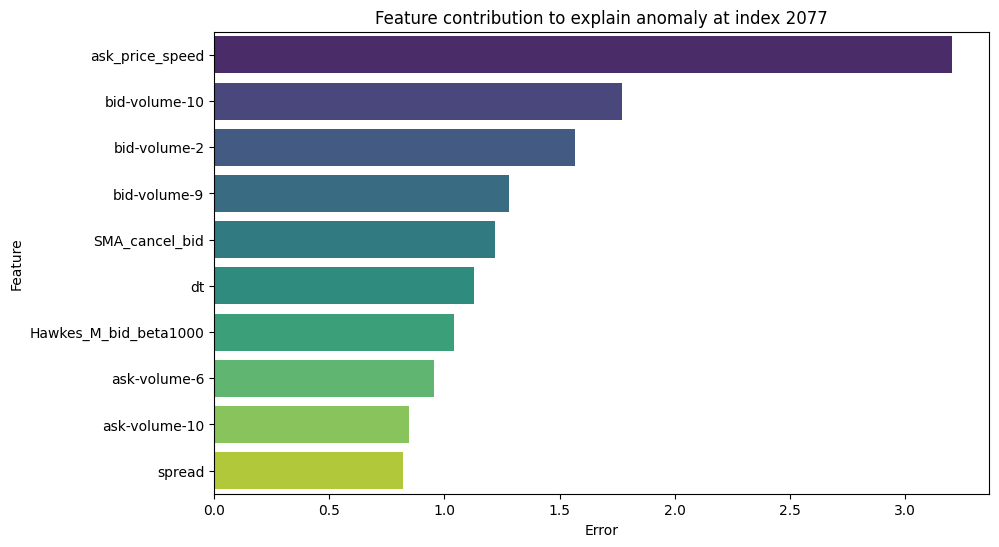

In [6]:
# Get the top anomaly index
top_anomaly_idx = anomalies_idx[np.argmax(anomaly_scores[anomalies_idx])]

# Get Input and Reconstructed Output for that specific sequence
seq_tensor = torch.tensor(pipeline.X_test[top_anomaly_idx]).unsqueeze(0).to(pipeline.device).float()

pipeline.model.eval()
with torch.no_grad():
    reconstructed_seq = pipeline.model(seq_tensor).cpu().numpy().squeeze()

input_seq = pipeline.X_test[top_anomaly_idx]

# Calculate Squared Error per feature (Mean over the sequence time dimension)
feature_errors = np.mean((input_seq - reconstructed_seq) ** 2, axis=0)

# Plot top 10 contributors to anomaly
feat_error_df = pd.DataFrame({
    'Feature': pipeline.feature_names,
    'Error': feature_errors
}).sort_values(by='Error', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_error_df, x='Error', y='Feature', hue='Feature', palette='viridis')
plt.title(f"Feature contribution to explain anomaly at index {top_anomaly_idx}")
plt.show()

In [18]:
# Train PNN Model
pipeline.train_model(
    model_type='pnn', 
    epochs=1, 
    lr=1e-3,
    hidden_dim=64
)

Initializing Probabilistic Neural Network (PNN)...
Training PNN...
Epoch 1/1 - Loss: 1.402705


Scanning for spoofing (Q=50000, dist=5 ticks)...


Found 1 potential spoofing opportunities.
Found 1 potential spoofing signatures.


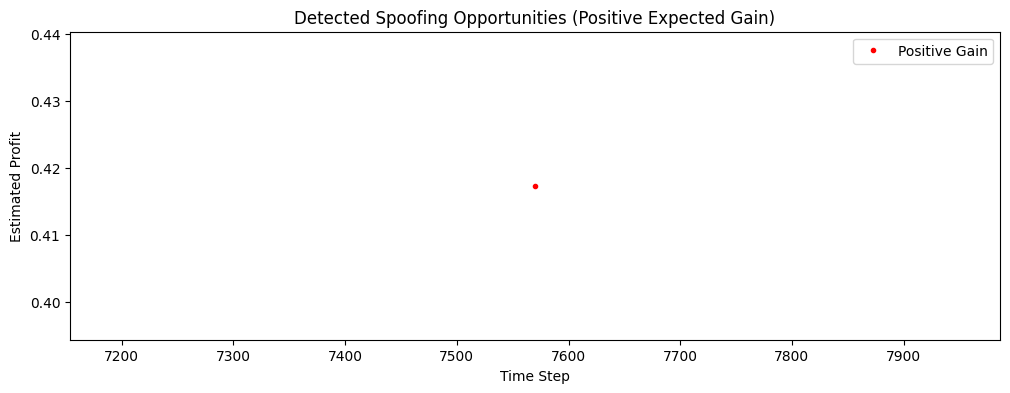

In [19]:
# Scan for anomalies using PNN
spoof_results = pipeline.detect_spoofing(
    Q_spoof=50000,    # Size of hypothetical spoof order
    delta_ticks=5,    # Distance away from best quote
    maker_fee=-0.002, # Negative fee (rebate) common in maker-taker markets
    taker_fee=0.003
)
if not spoof_results.empty:
    print(f"Found {len(spoof_results)} potential spoofing signatures.")
    
    # Plot expected gain over time
    plt.figure(figsize=(12, 4))
    plt.plot(spoof_results['Index'], spoof_results['Expected_Gain'], '.', color='red', label='Positive Gain')
    plt.title("Detected Spoofing Opportunities (Positive Expected Gain)")
    plt.xlabel("Time Step")
    plt.ylabel("Estimated Profit")
    plt.legend()
    plt.show()
else:
    print("No obvious spoofing opportunities detected with current parameters.")

Visualizing Order Book at most profitable moment: Index 7570


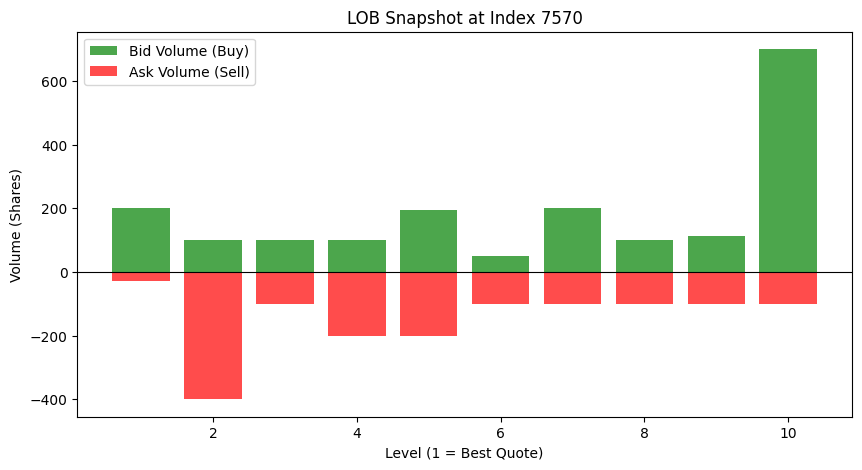

In [20]:
def plot_lob_snapshot(pipeline, index, levels=10):
    """Visualizes the Order Book shape at a specific index."""
    row = pipeline.raw_df.iloc[index]
    
    bids = [row[f'bid-volume-{i}'] for i in range(1, levels+1)]
    asks = [row[f'ask-volume-{i}'] for i in range(1, levels+1)]
    
    # Levels (1 to 10)
    x = np.arange(1, levels+1)
    
    plt.figure(figsize=(10, 5))
    plt.bar(x, bids, color='green', label='Bid Volume (Buy)', alpha=0.7)
    plt.bar(x, [-a for a in asks], color='red', label='Ask Volume (Sell)', alpha=0.7) # Negative for visual contrast
    
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel("Level (1 = Best Quote)")
    plt.ylabel("Volume (Shares)")
    plt.title(f"LOB Snapshot at Index {index}")
    plt.legend()
    plt.show()

# Visualize the most profitable spoofing opportunity found by PNN
if not spoof_results.empty:
    best_opportunity_idx = spoof_results.loc[spoof_results['Expected_Gain'].idxmax(), 'Index']
    print(f"Visualizing Order Book at most profitable moment: Index {best_opportunity_idx}")
    plot_lob_snapshot(pipeline, best_opportunity_idx)

Visualizing evolution around index 7570...


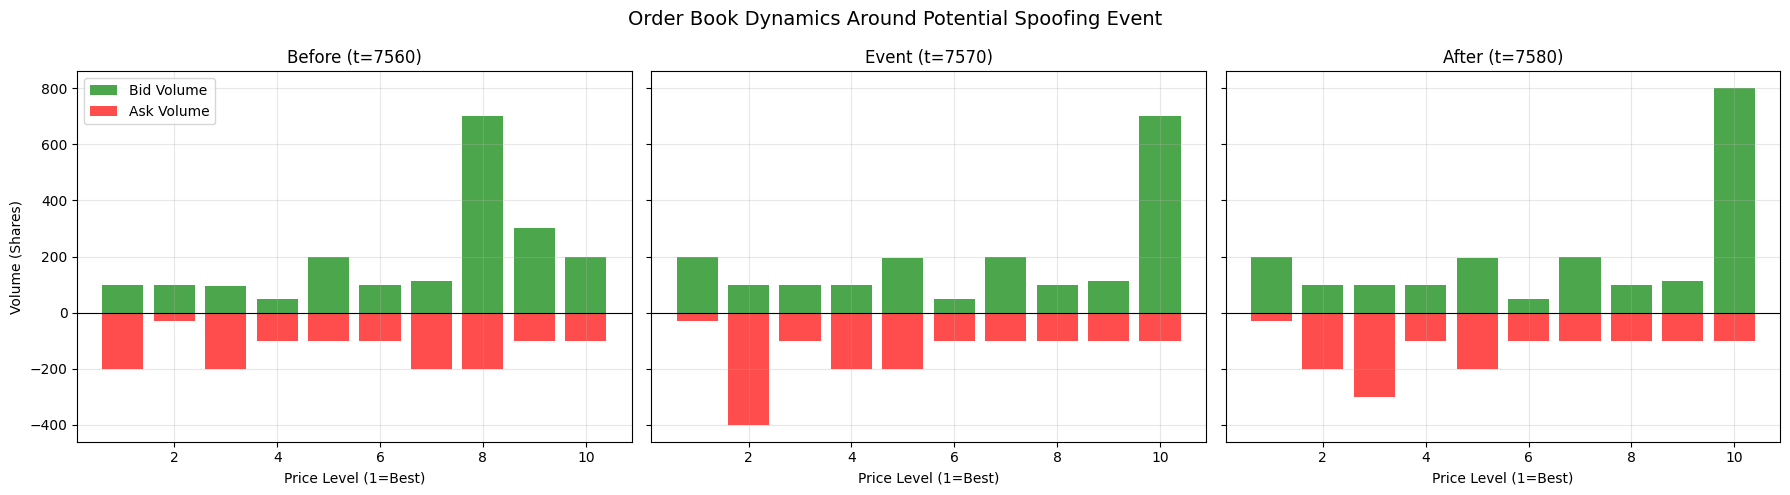

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lob_evolution(pipeline, center_index, offset=10, levels=10):
    """
    Plots LOB snapshots before, during, and after a specific index.
    
    Args:
        center_index: The time index of the detected anomaly.
        offset: Number of time steps to look before/after.
        levels: Number of price levels to display.
    """
    # Define time points: Before, Event, After
    indices = [center_index - offset, center_index, center_index + offset]
    titles = [f"Before (t={center_index - offset})", 
              f"Event (t={center_index})", 
              f"After (t={center_index + offset})"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    x = np.arange(1, levels + 1)
    
    for i, idx in enumerate(indices):
        # Safety check for index bounds
        if 0 <= idx < len(pipeline.raw_df):
            row = pipeline.raw_df.iloc[idx]
            
            # Extract volumes
            bids = [row[f'bid-volume-{l}'] for l in range(1, levels+1)]
            asks = [row[f'ask-volume-{l}'] for l in range(1, levels+1)]
            
            # Plot Bid (Green) vs Ask (Red/Negative)
            axes[i].bar(x, bids, color='green', label='Bid Volume' if i==0 else "", alpha=0.7)
            axes[i].bar(x, [-a for a in asks], color='red', label='Ask Volume' if i==0 else "", alpha=0.7)
            
            axes[i].axhline(0, color='black', linewidth=0.8)
            axes[i].set_title(titles[i])
            axes[i].set_xlabel("Price Level (1=Best)")
            axes[i].grid(True, alpha=0.3)
            
            if i == 0:
                axes[i].set_ylabel("Volume (Shares)")
                axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, "Index Out of Bounds", ha='center')

    plt.suptitle(f"Order Book Dynamics Around Potential Spoofing Event", fontsize=14)
    plt.tight_layout()
    plt.show()

if not spoof_results.empty:
    # Use the index of the most profitable opportunity
    best_idx = spoof_results.loc[spoof_results['Expected_Gain'].idxmax(), 'Index']
    
    print(f"Visualizing evolution around index {best_idx}...")
    plot_lob_evolution(pipeline, best_idx, offset=10)